In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# PyTorch
import torch
import torch.nn as nn
import torchmetrics

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import datasets
import models
from posteriors.swag import SWAG
import utils

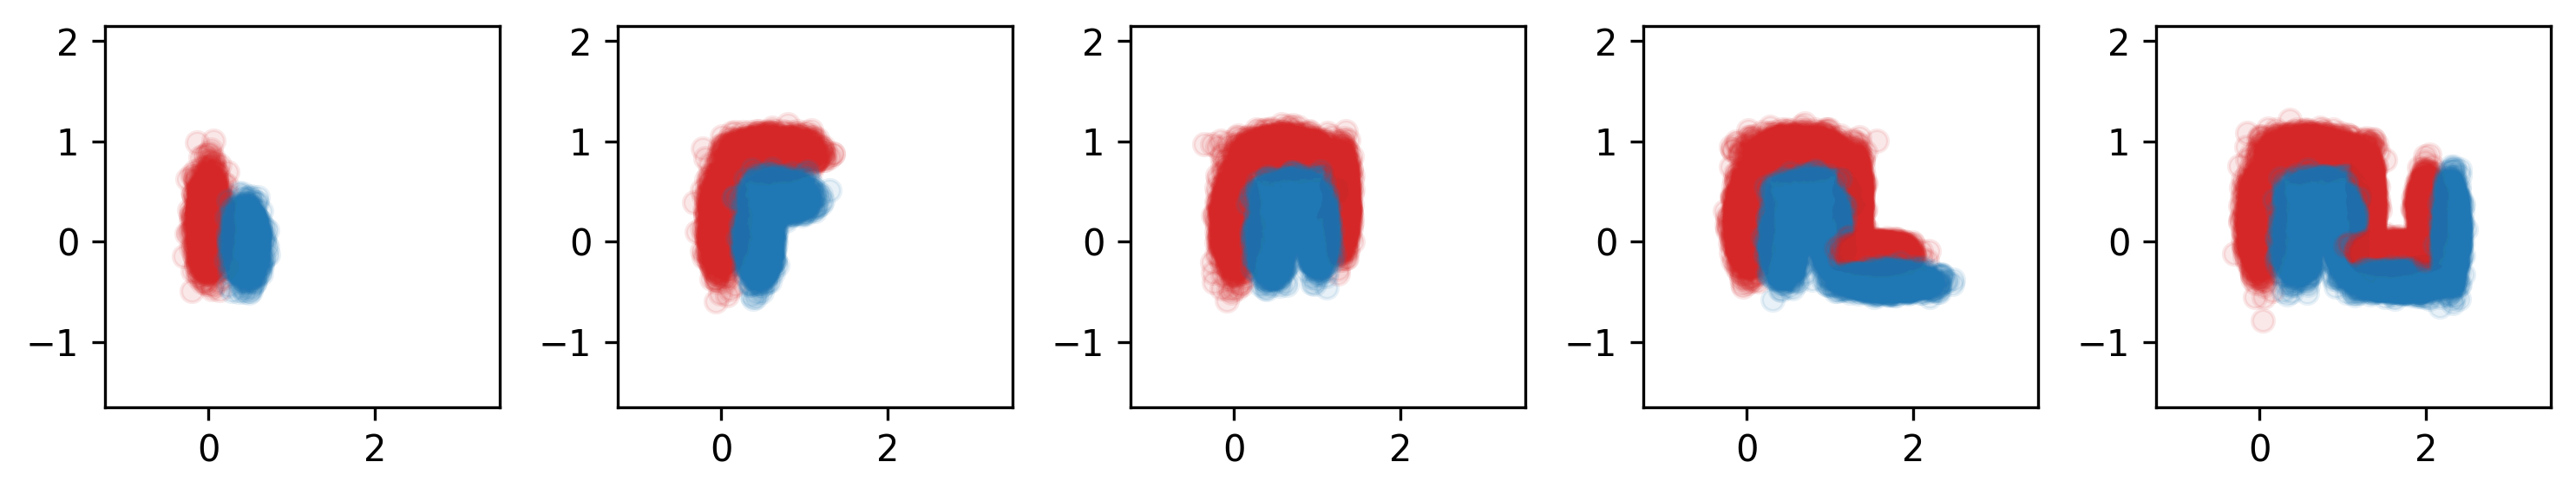

In [3]:
ncols, nrows = 5, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2*ncols, 2*nrows), dpi=300)

for i in range(5):
    toy_dataset = datasets.ToydataGenerator()
    for j in range(i+1):
        train_dataset, test_dataset = toy_dataset.next_task()
        axs[i].scatter(train_dataset[train_dataset[:][1]==0][0][:,0], train_dataset[train_dataset[:][1]==0][0][:,1], color='#D62728', alpha=0.1)
        axs[i].scatter(train_dataset[train_dataset[:][1]==1][0][:,0], train_dataset[train_dataset[:][1]==1][0][:,1], color='#1F77B4', alpha=0.1)
        axs[i].set_xlim([-1.25,3.5])
        axs[i].set_ylim([-1.65,2.15])
fig.tight_layout()
plt.show()

In [4]:
def train_one_epoch(model, criterion, optimizer, dataloader, acc=torchmetrics.Accuracy(task='binary'), prior=None):
    
    model.train()

    dataset_size = len(dataloader) * dataloader.batch_size if dataloader.drop_last else len(dataloader.dataset)
    metrics = {'acc': torch.tensor(0.0), 'labels': [], 'logits': [], 'loss': torch.tensor(0.0), 'nll': torch.tensor(0.0)}
    
    for inputs, labels in dataloader:
        
        model.zero_grad()
        logits = model(inputs)
        params = utils.flatten_params(model)
        nll = criterion(logits, labels)
        if prior: loss = nll - prior.log_prob(params)/dataset_size
        else: loss = nll
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        metrics['loss'] += len(inputs)/dataset_size*loss.item()
        metrics['nll'] += len(inputs)/dataset_size*nll.item()
        
        for label, logit in zip(labels, logits):
            metrics['labels'].append(label.detach())
            metrics['logits'].append(logit.detach())
            
    labels = torch.stack(metrics['labels'])
    logits = torch.stack(metrics['logits'])
    metrics['acc1'] = acc(logits[:,1], labels).item()
        
    return metrics

def evaluate(model, criterion, dataloader, acc=torchmetrics.Accuracy(task='binary'), prior=None):
    
    model.eval()
    
    dataset_size = len(dataloader) * dataloader.batch_size if dataloader.drop_last else len(dataloader.dataset)
    metrics = {'acc': torch.tensor(0.0), 'labels': [], 'logits': [], 'loss': torch.tensor(0.0), 'nll': torch.tensor(0.0)}
    
    with torch.no_grad():
        for inputs, labels in dataloader:
        
            logits = model(inputs)
            params = utils.flatten_params(model)
            nll = criterion(logits, labels)
            if prior: loss = nll - prior.log_prob(params)/dataset_size
            else: loss = nll
            
            metrics['loss'] += len(inputs)/dataset_size*loss.item()
            metrics['nll'] += len(inputs)/dataset_size*nll.item()
            
            for label, logit in zip(labels, logits):
                metrics['labels'].append(label.detach())
                metrics['logits'].append(logit.detach())

        labels = torch.stack(metrics['labels'])
        logits = torch.stack(metrics['logits'])
        metrics['acc1'] = acc(logits[:,1], labels).item()
        
    return metrics

def train_one_epoch_v2(model, criterion, optimizer, dataloader, context_inputs=None, num_samples=10, prior=None):
    
    model.train()

    dataset_size = len(dataloader) * dataloader.batch_size if dataloader.drop_last else len(dataloader.dataset)
    acc = torchmetrics.Accuracy(task='binary')
    metrics = {'acc': torch.tensor(0.0), 'labels': [], 'logits': [], 'loss': torch.tensor(0.0), 'nll': torch.tensor(0.0)}
    
    for inputs, labels in dataloader:
        
        if prior:
            state_dict = copy.deepcopy(model.state_dict())
            embeddings = []
            with torch.no_grad():
                for j in range(num_samples):
                    sampled_params = prior.sample()
                    torch.nn.utils.vector_to_parameters(sampled_params, model.parameters())
                    embedding_j = model(torch.cat(context_inputs, dim=0))
                    embeddings.append(embedding_j)
            embeddings = torch.stack(embeddings)
            model.load_state_dict(state_dict)
            
        model.zero_grad()
        logits = model(inputs)
        if prior: embedding = model(torch.cat(context_inputs, dim=0))
        nll = criterion(logits, labels)
        if prior: loss = nll - (1/dataset_size)*torch.logsumexp(torch.sum((-1/(2*1e-1**2))*torch.sum((embeddings-embedding)**2, dim=-1, keepdim=False), dim=-1, keepdim=False), dim=0, keepdim=False)
        else: loss = nll
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        metrics['loss'] += len(inputs)/dataset_size*loss.item()
        metrics['nll'] += len(inputs)/dataset_size*nll.item()
        
        for label, logit in zip(labels, logits):
            metrics['labels'].append(label.detach())
            metrics['logits'].append(logit.detach())
            
    labels = torch.stack(metrics['labels'])
    logits = torch.stack(metrics['logits'])
    metrics['acc1'] = acc(logits[:,1], labels).item()
        
    return metrics

def evaluate_v2(model, criterion, dataloader, context_inputs=None, num_samples=10, prior=None):
    
    model.eval()
    
    dataset_size = len(dataloader) * dataloader.batch_size if dataloader.drop_last else len(dataloader.dataset)
    acc = torchmetrics.Accuracy(task='binary')
    metrics = {'acc': torch.tensor(0.0), 'labels': [], 'logits': [], 'loss': torch.tensor(0.0), 'nll': torch.tensor(0.0)}
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            
            if prior:
                state_dict = copy.deepcopy(model.state_dict())
                embeddings = []
                with torch.no_grad():
                    for j in range(num_samples):
                        sampled_params = prior.sample()
                        torch.nn.utils.vector_to_parameters(sampled_params, model.parameters())
                        embedding_j = model(torch.cat(context_inputs, dim=0))
                        embeddings.append(embedding_j)
                embeddings = torch.stack(embeddings)
                model.load_state_dict(state_dict)
        
            logits = model(inputs)
            if prior: embedding = model(torch.cat(context_inputs, dim=0))
            nll = criterion(logits, labels)
            if prior: loss = nll - (1/dataset_size)*torch.logsumexp(torch.sum((-1/(2*1e-1**2))*torch.sum((embeddings-embedding)**2, dim=-1, keepdim=False), dim=-1, keepdim=False), dim=0, keepdim=False)
            else: loss = nll

            metrics['loss'] += len(inputs)/dataset_size*loss.item()
            metrics['nll'] += len(inputs)/dataset_size*nll.item()
            
            for label, logit in zip(labels, logits):
                metrics['labels'].append(label.detach())
                metrics['logits'].append(logit.detach())

        labels = torch.stack(metrics['labels'])
        logits = torch.stack(metrics['logits'])
        metrics['acc1'] = acc(logits[:,1], labels).item()
        
    return metrics

In [5]:
toy_dataset = datasets.ToydataGenerator()

train_accs, train_losses, train_nlls = [[] for _ in range(5)], [[] for _ in range(5)], [[] for _ in range(5)]
test_accs, test_losses, test_nlls = [[] for _ in range(5)], [[] for _ in range(5)], [[] for _ in range(5)]

context_inputs, context_labels = [], []
swag_models = []

model = models.Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)

for i in range(5):
    swag_model = SWAG(model)
    
    train_dataset, test_dataset = toy_dataset.next_task()
    
    # TODO: This code adds context points to the training dataset.
    #if len(swag_models):
    #    context_dataset = torch.utils.data.TensorDataset(torch.cat(context_inputs, dim=0), torch.cat(context_labels, dim=0))
    #    expanded_train_dataset = torch.utils.data.ConcatDataset([train_dataset, context_dataset])
    #else:
    #    expanded_train_dataset = train_dataset
    expanded_train_dataset = train_dataset
    
    shuffled_train_loader = torch.utils.data.DataLoader(expanded_train_dataset, batch_size=128, shuffle=True)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

    for epoch in range(1_000):
        if len(swag_models): shuffled_train_metrics = train_one_epoch(model, criterion, optimizer, shuffled_train_loader, prior=swag_models[-1])
        else: shuffled_train_metrics = train_one_epoch(model, criterion, optimizer, shuffled_train_loader)
        train_accs[i].append(shuffled_train_metrics['acc'])
        train_losses[i].append(shuffled_train_metrics['loss'])
        train_nlls[i].append(shuffled_train_metrics['nll'])
    
    utils.adjust_learning_rate(optimizer, 0.01)

    for sampling_epoch in range(20):
        if len(swag_models): shuffled_train_metrics = train_one_epoch(model, criterion, optimizer, shuffled_train_loader, prior=swag_models[-1])
        else: shuffled_train_metrics = train_one_epoch(model, criterion, optimizer, shuffled_train_loader)
        swag_model.collect_model(model)
        
    # TODO: Evaluate 
    if len(swag_models): train_metrics = evaluate(model, criterion, train_loader, prior=swag_models[-1])
    else: train_metrics = evaluate(model, criterion, train_loader)
    squared_errors = (torch.sum(torch.nn.functional.one_hot(torch.stack(train_metrics['labels']))-torch.nn.functional.softmax(torch.stack(train_metrics['logits']), dim=-1), dim=-1, keepdim=False))**2
    topk_error_indices = torch.topk(squared_errors.view(-1), 40).indices
    print(topk_error_indices)
        
    swag_models.append(copy.deepcopy(swag_model))
    context_inputs.append(train_dataset[topk_error_indices][0])
    context_labels.append(train_dataset[topk_error_indices][1])
    
    utils.adjust_learning_rate(optimizer, 0.01)

tensor([3924, 3475, 2578, 2218, 3497, 3053, 1476, 2868, 2774, 1565, 2619, 2880,
         625, 2146, 1701,  785, 3280, 3498, 1807, 1548, 1229, 3611,  149,  749,
         743,  187, 1751, 1094, 1982, 1249, 1901, 2500, 2153, 2964, 1645,  528,
         480,  763, 1971, 2361])
tensor([2066, 2397, 2065,  861, 2948, 2274, 2251, 2898, 2316, 3715, 3201, 1253,
        2878, 1618, 2548, 2022, 1811, 2932, 1150, 1763, 3123, 2928, 2486, 2167,
        2395, 3022, 2116, 3118, 2799, 1943, 3362, 3649, 1824, 1640, 3347,  361,
        2354, 2703,  207, 2381])
tensor([1049,  755,  689, 3788,  686,  728, 2335, 3190, 1960, 3013, 3672, 3423,
        3918, 2943,  236, 3561, 3953, 3120, 3952, 3278, 3559,  295, 2470, 3928,
        2644, 3785, 2048, 3668, 3438, 2776, 2099, 3114, 3776, 3934, 2011, 2511,
        2098, 3141, 2833, 2088])
tensor([1016,  364, 1513, 1349, 1957, 1693,  854, 1949, 1849, 1855, 3403,  439,
        1379, 1359,  738,  640, 1333, 1100, 1962, 1608, 2854,  520, 1098, 2921,
          38,  121,  

In [6]:
# Note: This line saves the list of swag models.
for index, swag_model in enumerate(swag_models): swag_model.save(f'./ps_prior_{index}')
swag_models = []
for index in range(5):
    model = models.Classifier()
    swag_model = SWAG(model)
    swag_model.load(f'./ps_prior_{index}')
    swag_models.append(copy.deepcopy(swag_model))

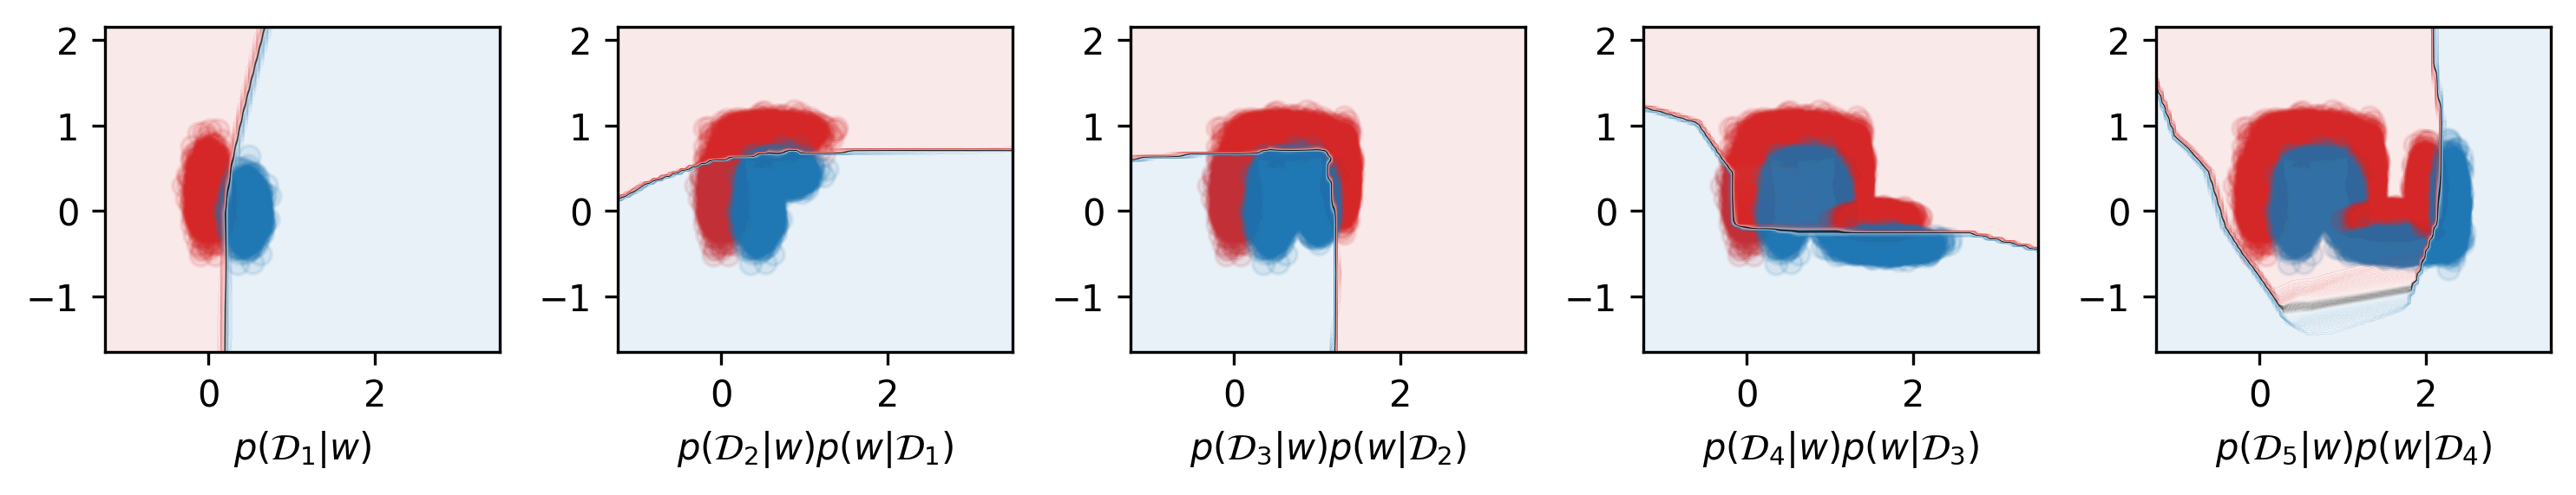

In [7]:
def black_middle_cmap():
    colors = ['#1F77B4', '#5799C7', '#8FBBDA', '#C7DDEC', '#000000', 
              '#000000', '#F5C9C9', '#EB9394', '#E05D5E', '#D62728']
    positions = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    return LinearSegmentedColormap.from_list('black_middle', colors, N=256)

x_values = np.linspace(-1.25, 3.5, 100)
y_values = np.linspace(-1.65, 2.15, 100)
xx, yy = np.meshgrid(x_values, y_values)

inputs = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

num_samples = 1
xlabels = [r'$p(\mathcal{D}_1 | w)$', 
           r'$p(\mathcal{D}_2 | w) p(w | \mathcal{D}_1)$', 
           r'$p(\mathcal{D}_3 | w) p(w | \mathcal{D}_2)$', 
           r'$p(\mathcal{D}_4 | w) p(w | \mathcal{D}_3)$', 
           r'$p(\mathcal{D}_5 | w) p(w | \mathcal{D}_4)$']

ncols, nrows = 5, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2*ncols, 2*nrows), dpi=300)

toy_dataset = datasets.ToydataGenerator()
for i in range(5):
    train_dataset, test_dataset = toy_dataset.next_task()
    for j in range(i, 5):
        axs[j].scatter(train_dataset[train_dataset[:][1]==0][0][:,0], train_dataset[train_dataset[:][1]==0][0][:,1], color='#D62728', alpha=0.1)
        axs[j].scatter(train_dataset[train_dataset[:][1]==1][0][:,0], train_dataset[train_dataset[:][1]==1][0][:,1], color='#1F77B4', alpha=0.1)
    
    with torch.no_grad():
        for _ in range(num_samples):
            sampled_params = swag_models[i].loc
            torch.nn.utils.vector_to_parameters(sampled_params, model.parameters())
            outputs = torch.nn.functional.softmax(model(inputs), dim=-1).reshape((100, 100, -1))
            axs[i].contourf(xx, yy, outputs[:,:,0], cmap=black_middle_cmap(), levels=np.linspace(0.0, 1.0, 100), vmin=0, vmax=1.0, alpha=0.1)
        
    axs[i].set_xlim([-1.25, 3.5])
    axs[i].set_ylim([-1.65, 2.15])
    axs[i].set_xlabel(xlabels[i])
    
fig.tight_layout()
plt.show()

In [ ]:
toy_dataset = datasets.ToydataGenerator()

train_accs, train_losses, train_nlls = [[] for _ in range(5)], [[] for _ in range(5)], [[] for _ in range(5)]
test_accs, test_losses, test_nlls = [[] for _ in range(5)], [[] for _ in range(5)], [[] for _ in range(5)]

swag_models = []
context_inputs = []

model = models.Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)

for i in range(5):
    swag_model = SWAG(model)
    
    train_dataset, test_dataset = toy_dataset.next_task()
    shuffled_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

    for epoch in range(1_000):
        if len(swag_models): shuffled_train_metrics = train_one_epoch_v2(model, criterion, optimizer, shuffled_train_loader, context_inputs=context_inputs, prior=swag_models[-1])
        else: shuffled_train_metrics = train_one_epoch_v2(model, criterion, optimizer, shuffled_train_loader)
        train_accs[i].append(shuffled_train_metrics['acc'])
        train_losses[i].append(shuffled_train_metrics['loss'])
        train_nlls[i].append(shuffled_train_metrics['nll'])
    
    utils.adjust_learning_rate(optimizer, 0.01)

    for sampling_epoch in range(20):
        if len(swag_models): shuffled_train_metrics = train_one_epoch_v2(model, criterion, optimizer, shuffled_train_loader, context_inputs=context_inputs, prior=swag_models[-1])
        else: shuffled_train_metrics = train_one_epoch_v2(model, criterion, optimizer, shuffled_train_loader)
        swag_model.collect_model(model)
        
    # TODO: Evaluate 
    if len(swag_models): train_metrics = evaluate_v2(model, criterion, train_loader, context_inputs=context_inputs, prior=swag_models[-1])
    else: train_metrics = evaluate_v2(model, criterion, train_loader)
    squared_errors = (torch.sum(torch.nn.functional.one_hot(torch.stack(train_metrics['labels']))-torch.nn.functional.softmax(torch.stack(train_metrics['logits']), dim=-1), dim=-1, keepdim=False))**2
    topk_error_indices = torch.topk(squared_errors.view(-1), 40).indices
    print(topk_error_indices)
    
    swag_models.append(copy.deepcopy(swag_model))
    context_inputs.append(train_dataset[topk_error_indices][0])
        
    utils.adjust_learning_rate(optimizer, 0.001)

tensor([ 429, 1236,  748, 2891, 1091, 2902, 2059, 3385, 2198, 3915, 3650, 2144,
        2552, 3288, 2397, 2187, 2990, 2623, 3283, 2675,  953, 2799,   53,  682,
        1348, 2114,  520, 2649,  132, 2587, 2007, 2244,  830, 3868, 2303, 3290,
        2157, 2286, 2953, 1673])
tensor([2707,  338, 3857, 1568, 2840, 2602, 1834, 2827, 2759, 2371, 2560, 2950,
         776, 2997, 2625, 3952, 3517, 2173, 2650,  725, 3253, 2809,  895, 3626,
        3143, 2694, 3298,  711, 2072, 3640, 3543, 1140, 2482, 3558, 3869, 1221,
        3859, 3257, 2155, 3399])
tensor([  46, 1253, 1394, 1787, 2025, 1254,  853, 1606, 2585, 1593,  175, 3532,
        3249,  233,  751, 1983, 2400, 3237, 3110,  744,  468, 1379, 2507,  710,
        1424,  417,   22, 3389,  171,  692, 1695,  102, 1214,  350, 2324,  161,
        3636, 2671,  410, 1978])
tensor([1412,  574,  565,  713, 1677,  594, 1686, 1271,   23,  241, 2208, 1512,
        1064,  932,  330, 1327, 1815,  357, 3053, 1135,  749, 1297, 2243,  156,
        1267, 1181, 1

In [ ]:
# Note: This line saves the list of swag models.
for index, swag_model in enumerate(swag_models): swag_model.save(f'./fs_prior_{index}')
swag_models = []
for index in range(5):
    model = models.Classifier()
    swag_model = SWAG(model)
    swag_model.load(f'./fs_prior_{index}')
    swag_models.append(copy.deepcopy(swag_model))

In [ ]:
model = models.Classifier()
criterion = nn.CrossEntropyLoss()

x_values = np.linspace(-1.25, 3.5, 100)
y_values = np.linspace(-1.65, 2.15, 100)
xx, yy = np.meshgrid(x_values, y_values)

inputs = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

num_samples = 1
xlabels = [r'$p(\mathcal{D}_1 | f_w)$', 
           r'$p(\mathcal{D}_2 | f_w) p(f_w | \mathcal{D}_1)$', 
           r'$p(\mathcal{D}_3 | f_w) p(f_w | \mathcal{D}_2)$', 
           r'$p(\mathcal{D}_4 | f_w) p(f_w | \mathcal{D}_3)$', 
           r'$p(\mathcal{D}_5 | f_w) p(f_w | \mathcal{D}_4)$']

ncols, nrows = 5, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2*ncols, 2*nrows), dpi=300)

toy_dataset = datasets.ToydataGenerator()
for i in range(5):
    train_dataset, test_dataset = toy_dataset.next_task()
    for j in range(i, 5):
        axs[j].scatter(train_dataset[train_dataset[:][1]==0][0][:,0], train_dataset[train_dataset[:][1]==0][0][:,1], color='#D62728', alpha=0.1)
        axs[j].scatter(train_dataset[train_dataset[:][1]==1][0][:,0], train_dataset[train_dataset[:][1]==1][0][:,1], color='#1F77B4', alpha=0.1)

        if i != j:
            sampled_params = swag_models[i-1].loc
            torch.nn.utils.vector_to_parameters(sampled_params, model.parameters())
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
            train_metrics = evaluate(model, criterion, train_loader)
            squared_errors = (torch.sum(torch.nn.functional.one_hot(torch.stack(train_metrics['labels']))-torch.nn.functional.softmax(torch.stack(train_metrics['logits']), dim=-1), dim=-1, keepdim=False))**2
            topk_error_indices = torch.topk(squared_errors.view(-1), 40).indices
            axs[j].scatter(train_dataset[topk_error_indices][0][:,0], train_dataset[topk_error_indices][0][:,1], alpha=0.1, color='black', marker='*')

    with torch.no_grad():
        for _ in range(num_samples):
            sampled_params = swag_models[i].loc
            torch.nn.utils.vector_to_parameters(sampled_params, model.parameters())
            outputs = torch.nn.functional.softmax(model(inputs), dim=-1).reshape((100, 100, -1))
            axs[i].contourf(xx, yy, outputs[:,:,0], cmap=black_middle_cmap(), levels=np.linspace(0.0, 1.0, 100), vmin=0, vmax=1.0, alpha=0.1)
        
    axs[i].set_xlim([-1.25, 3.5])
    axs[i].set_ylim([-1.65, 2.15])
    axs[i].set_xlabel(xlabels[i])

fig.tight_layout()
plt.show()

In [ ]:
toy_dataset = datasets.ToydataGenerator()

train_accs, train_losses, train_nlls = [[] for _ in range(5)], [[] for _ in range(5)], [[] for _ in range(5)]
test_accs, test_losses, test_nlls = [[] for _ in range(5)], [[] for _ in range(5)], [[] for _ in range(5)]

swag_models = []

model = models.Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)

for i in range(5):
    swag_model = SWAG(model)
    
    train_dataset, test_dataset = toy_dataset.next_task()
    shuffled_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

    for epoch in range(1_000):
        
        context_inputs = [torch.stack([torch.rand([1])*(3.5 + 1.25)-1.25, torch.rand([1])*(2.15 + 1.65)-1.65], dim=-1) for _ in range(100)]
        
        if len(swag_models): shuffled_train_metrics = train_one_epoch_v2(model, criterion, optimizer, shuffled_train_loader, context_inputs=context_inputs, prior=swag_models[-1])
        else: shuffled_train_metrics = train_one_epoch_v2(model, criterion, optimizer, shuffled_train_loader)
        train_accs[i].append(shuffled_train_metrics['acc'])
        train_losses[i].append(shuffled_train_metrics['loss'])
        train_nlls[i].append(shuffled_train_metrics['nll'])
    
    utils.adjust_learning_rate(optimizer, 0.01)

    for sampling_epoch in range(20):
        if len(swag_models): shuffled_train_metrics = train_one_epoch_v2(model, criterion, optimizer, shuffled_train_loader, context_inputs=context_inputs, prior=swag_models[-1])
        else: shuffled_train_metrics = train_one_epoch_v2(model, criterion, optimizer, shuffled_train_loader)
        swag_model.collect_model(model)
        
    swag_models.append(copy.deepcopy(swag_model))
        
    utils.adjust_learning_rate(optimizer, 0.001)

In [ ]:
# Note: This line saves the list of swag models.
for index, swag_model in enumerate(swag_models): swag_model.save(f'./grid_fs_prior_{index}')
swag_models = []
for index in range(5):
    model = models.Classifier()
    swag_model = SWAG(model)
    swag_model.load(f'./grid_fs_prior_{index}')
    swag_models.append(copy.deepcopy(swag_model))

In [ ]:
model = models.Classifier()
criterion = nn.CrossEntropyLoss()

context_inputs = [torch.stack([torch.rand([1])*(3.5 + 1.25)-1.25, torch.rand([1])*(2.15 + 1.65)-1.65], dim=-1) for _ in range(100)]

x_values = np.linspace(-1.25, 3.5, 100)
y_values = np.linspace(-1.65, 2.15, 100)
xx, yy = np.meshgrid(x_values, y_values)

inputs = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

num_samples = 1
xlabels = [r'$p(\mathcal{D}_1 | f_w)$', 
           r'$p(\mathcal{D}_2 | f_w) p(f_w | \mathcal{D}_1)$', 
           r'$p(\mathcal{D}_3 | f_w) p(f_w | \mathcal{D}_2)$', 
           r'$p(\mathcal{D}_4 | f_w) p(f_w | \mathcal{D}_3)$', 
           r'$p(\mathcal{D}_5 | f_w) p(f_w | \mathcal{D}_4)$']

ncols, nrows = 5, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2*ncols, 2*nrows), dpi=300)

toy_dataset = datasets.ToydataGenerator()
for i in range(5):
    train_dataset, test_dataset = toy_dataset.next_task()
    for j in range(i, 5):
        axs[j].scatter(train_dataset[train_dataset[:][1]==0][0][:,0], train_dataset[train_dataset[:][1]==0][0][:,1], color='#D62728', alpha=0.1)
        axs[j].scatter(train_dataset[train_dataset[:][1]==1][0][:,0], train_dataset[train_dataset[:][1]==1][0][:,1], color='#1F77B4', alpha=0.1)

        if i == j-1:
            axs[j].scatter(torch.cat(context_inputs, dim=0)[:,0], torch.cat(context_inputs, dim=0)[:,1], alpha=0.1, color='black', marker='*')

    with torch.no_grad():
        for _ in range(num_samples):
            sampled_params = swag_models[i].loc
            torch.nn.utils.vector_to_parameters(sampled_params, model.parameters())
            outputs = torch.nn.functional.softmax(model(inputs), dim=-1).reshape((100, 100, -1))
            axs[i].contourf(xx, yy, outputs[:,:,0], cmap=black_middle_cmap(), levels=np.linspace(0.0, 1.0, 100), vmin=0, vmax=1.0, alpha=0.1)
        
    axs[i].set_xlim([-1.25, 3.5])
    axs[i].set_ylim([-1.65, 2.15])
    axs[i].set_xlabel(xlabels[i])

fig.tight_layout()
plt.show()